In [1]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



🔍 Train Set Evaluation (Best Model from Grid Search):
Accuracy: 1.0
Balanced Accuracy: 1.0

🔍 Validation Set Evaluation (Best Model from Grid Search):
Accuracy: 0.9401041666666666
Balanced Accuracy: 0.9401041666666667


🧪 Test Set (Final Model) Performance
Accuracy: 0.8842845973416732
Balanced Accuracy: 0.8235473405493482
                      precision    recall  f1-score   support

       No Impairment     0.8927    0.9234    0.9078       640
Very Mild Impairment     0.8690    0.8438    0.8562       448
     Mild Impairment     0.8851    0.8603    0.8725       179
 Moderate Impairment     1.0000    0.6667    0.8000        12

            accuracy                         0.8843      1279
           macro avg     0.9117    0.8235    0.8591      1279
        weighted avg     0.8843    0.8843    0.8838      1279



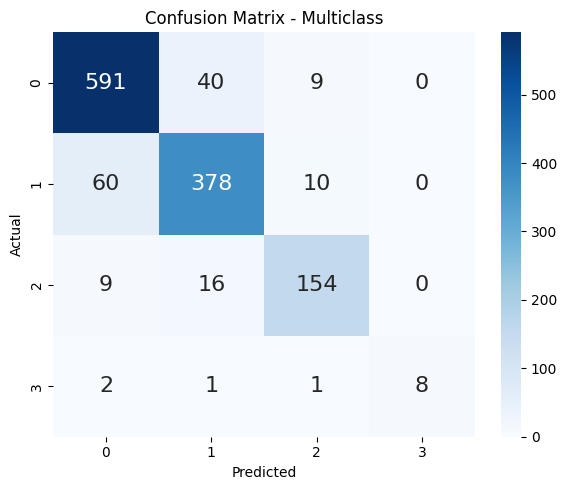

In [14]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score
)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# --- Load Datasets ---
df = pd.read_csv("train_features_scaled.csv")
val_df = pd.read_csv("val_features_scaled.csv")
test_df = pd.read_csv("test_features_scaled.csv")

# --- Feature Selection ---
X_all = df.drop(columns=["label", "label_name"], errors="ignore")
y_all = df["label"]

f_scores, _ = f_classif(X_all, y_all)
mi_scores = mutual_info_classif(X_all, y_all, random_state=42)

f_df = pd.DataFrame({"Feature": X_all.columns, "F_score": f_scores})
mi_df = pd.DataFrame({"Feature": X_all.columns, "MI_Score": mi_scores})

top_f = set(f_df.nlargest(120, "F_score")["Feature"])
top_mi = set(mi_df.nlargest(120, "MI_Score")["Feature"])
core_features = list(top_f & top_mi)

# --- Extract Features and Labels ---
X_train = df[core_features]
y_train = df["label"]
X_val = val_df[core_features]
y_val = val_df["label"]
X_test = test_df[core_features]
y_test = test_df["label"]

# --- Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# # --- Manual Grid Search using Validation Set ---
# param_grid = {
#     'C': [0.1, 1, 10, 25, 50, 75, 100],
#     'gamma': ['scale', 0.01, 0.001]
# }
# best_score = 0
# best_params = {}
# 
# print("🔍 Hyperparameter tuning on validation set:")
# for C, gamma in product(param_grid['C'], param_grid['gamma']):
#     model = SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced',
#                 probability=True, random_state=42)
#     model.fit(X_train_scaled, y_train)
#     val_pred = model.predict(X_val_scaled)
#     val_score = balanced_accuracy_score(y_val, val_pred)
#     print(f"Tested C={C}, gamma={gamma} → Balanced Accuracy: {val_score:.4f}")
#     if val_score > best_score:
#         best_score = val_score
#         best_params = {'C': C, 'gamma': gamma}
# 
# print("\n✅ Best Params from validation set:")
# print(best_params)
# print(f"Best Validation Balanced Accuracy: {best_score:.4f}")

best_params = {
    'C': 35,
    'gamma': 0.01
}

# Re-train best model on training set only
best_model = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel='rbf',
                 class_weight='balanced', probability=True, random_state=42)
best_model.fit(X_train_scaled, y_train)

# Evaluate on train set
print("\n🔍 Train Set Evaluation (Best Model from Grid Search):")
train_pred = best_model.predict(X_train_scaled)
print("Accuracy:", accuracy_score(y_train, train_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_train, train_pred))
print()

# Evaluate on validation set
print("🔍 Validation Set Evaluation (Best Model from Grid Search):")
val_pred = best_model.predict(X_val_scaled)
print("Accuracy:", accuracy_score(y_val, val_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_val, val_pred))
print()


# --- Combine Train + Val for Final Training ---
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])
X_combined_scaled = scaler.fit_transform(X_combined)

# --- Train Final Model on Combined Data ---

clf = SVC(
    C=best_params['C'],
    gamma=best_params['gamma'],
    kernel='rbf',
    class_weight={0: 1, 1: 3, 2: 5, 3: 14}, 
    probability=True,
    random_state=42
)

clf.fit(X_combined_scaled, y_combined)

# --- Evaluation Utility ---
label_map = {
    0: "No Impairment",
    1: "Very Mild Impairment",
    2: "Mild Impairment",
    3: "Moderate Impairment"
}

def evaluate_set(X, y, dataset_name="Set"):
    y_pred = clf.predict(X)
    print(f"\n🧪 {dataset_name} Performance")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map.values(), digits=4))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map.keys(), yticklabels=label_map.keys(), annot_kws={"size": 16})
    plt.title(f"Confusion Matrix - Multiclass")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"./img/confusion_matrix_svm_{dataset_name.lower().replace(' ', '_')}.png")
    plt.show()

# --- Evaluate Final Model ---
X_test_final_scaled = scaler.transform(X_test)
evaluate_set(X_test_final_scaled, y_test, "Test Set (Final Model)")



🧪 Test Set Performance (Binary, Threshold = 0.45)
Accuracy: 0.8858483189992181
Balanced Accuracy: 0.8858592527386542
               precision    recall  f1-score   support

No Impairment     0.8971    0.8719    0.8843       640
     Impaired     0.8752    0.8998    0.8873       639

     accuracy                         0.8858      1279
    macro avg     0.8861    0.8859    0.8858      1279
 weighted avg     0.8862    0.8858    0.8858      1279



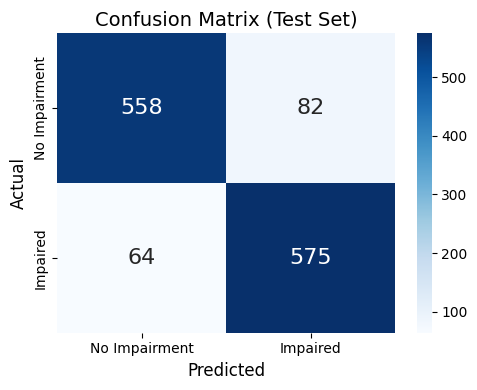

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score
)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# --- Load Datasets ---
df = pd.read_csv("train_features.csv")
val_df = pd.read_csv("val_features.csv")
test_df = pd.read_csv("test_features.csv")

# --- Relabel to Binary: 0 = No Impairment, 1 = Any Impairment ---
df['label'] = df['label'].apply(lambda x: 0 if x == 0 else 1)
val_df['label'] = val_df['label'].apply(lambda x: 0 if x == 0 else 1)
test_df['label'] = test_df['label'].apply(lambda x: 0 if x == 0 else 1)

# --- Feature Selection ---
X_all = df.drop(columns=["label", "label_name"], errors="ignore")
y_all = df["label"]

f_scores, _ = f_classif(X_all, y_all)
mi_scores = mutual_info_classif(X_all, y_all, random_state=42)

f_df = pd.DataFrame({"Feature": X_all.columns, "F_score": f_scores})
mi_df = pd.DataFrame({"Feature": X_all.columns, "MI_Score": mi_scores})

top_f = set(f_df.nlargest(120, "F_score")["Feature"])
top_mi = set(mi_df.nlargest(120, "MI_Score")["Feature"])
core_features = list(top_f & top_mi)

# --- Extract Features and Labels ---
X_train = df[core_features]
y_train = df["label"]
X_val = val_df[core_features]
y_val = val_df["label"]
X_test = test_df[core_features]
y_test = test_df["label"]

# --- Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Manual Grid Search using Validation Set ---
# param_grid = {
#     'C': [0.1, 1, 10, 25, 50, 75, 100],
#     'gamma': ['scale', 0.01, 0.001]
# }
# best_score = 0
# best_params = {}
# 
# print("🔍 Hyperparameter tuning on validation set (binary):")
# for C, gamma in product(param_grid['C'], param_grid['gamma']):
#     model = SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced',
#                 probability=True, random_state=42)
#     model.fit(X_train_scaled, y_train)
#     val_pred = model.predict(X_val_scaled)
#     val_score = balanced_accuracy_score(y_val, val_pred)
#     print(f"Tested C={C}, gamma={gamma} → Balanced Accuracy: {val_score:.4f}")
#     if val_score > best_score:
#         best_score = val_score
#         best_params = {'C': C, 'gamma': gamma}
# 
# print("\n✅ Best Params from validation set (binary):")
# 
# print(best_params)
# print(f"Best Validation Balanced Accuracy: {best_score:.4f}")


# After fine tuning, these are the best parameters found:
best_params = {
    'C': 10,
    'gamma': 0.01,
}

# --- Combine Train + Val for Final Training ---
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])
X_combined_scaled = scaler.fit_transform(X_combined)

# --- Train Final Model on Combined Data ---
clf = SVC(
    C=best_params['C'],
    gamma=best_params['gamma'],
    kernel='rbf',
    class_weight='balanced',
    probability=True,
    random_state=42
)
clf.fit(X_combined_scaled, y_combined)

# --- Evaluation Utility ---
label_map_binary = {
    0: "No Impairment",
    1: "Impaired"
}

def evaluate_binary(X, y, dataset_name="Set", threshold=0.5):
    probs = clf.predict_proba(X)[:, 1]  # Probability of class 1 (Impaired)
    y_pred = (probs >= threshold).astype(int)

    print(f"\n🧪 {dataset_name} Performance (Binary, Threshold = {threshold})")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map_binary.values(), digits=4))
    
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        annot_kws={"size": 16},  # Increase font size here
        xticklabels=label_map_binary.values(),
        yticklabels=label_map_binary.values()
    )
    plt.title(f"Confusion Matrix ({dataset_name})", fontsize=14)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"./img/confusion_matrix_{dataset_name.replace(' ', '_').lower()}_threshold_{threshold}.png")
    plt.show()


def get_roc_metrics(y_true, y_proba, threshold=0.5):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    
    # Find the closest threshold in the ROC curve
    closest_index = np.argmin(np.abs(thresholds - threshold))
    selected_fpr = fpr[closest_index]
    selected_tpr = tpr[closest_index]
    
    print(f"\n📊 ROC Metrics at Threshold {threshold}:")
    print(f"AUC Score: {auc_score:.4f}")
    print(f"True Positive Rate (Recall): {selected_tpr:.4f}")
    print(f"False Positive Rate: {selected_fpr:.4f}")
    print(f"Threshold used: {thresholds[closest_index]:.4f}"
    )
    

# --- Evaluate Final Model ---
X_test_final_scaled = scaler.transform(X_test)
evaluate_binary(X_test_final_scaled, y_test, f"Test Set", threshold=0.35)